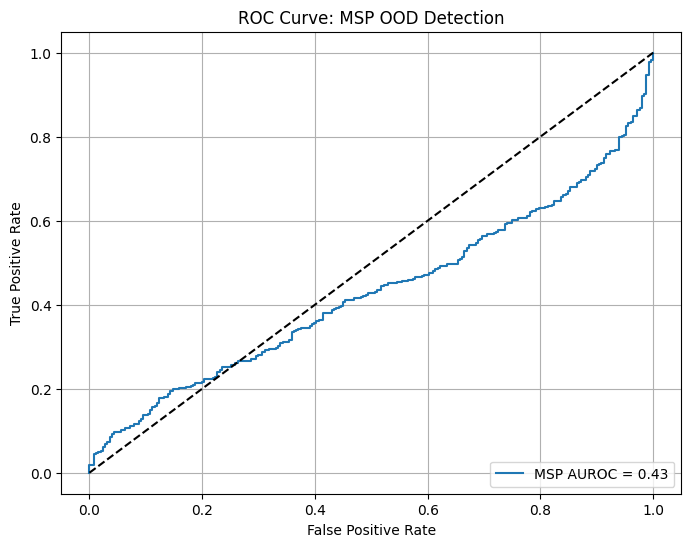

In [6]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# === Set device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load trained model ===
model = models.resnet18()
model.fc = torch.nn.Linear(model.fc.in_features, 1)
model.load_state_dict(torch.load("../models/resnet18_id_only.pth", map_location=device))
model.to(device)
model.eval()

# === Define transformation ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# === Load ID and OOD data ===
id_path = r"D:\\ODD PROJECT\\DATA\\BDD\\scene_classification\\id"
ood_path = r"D:\\ODD PROJECT\\DATA\\BDD\\scene_classification\\ood"

id_dataset = datasets.ImageFolder(root=id_path, transform=transform)
ood_dataset = datasets.ImageFolder(root=ood_path, transform=transform)

id_loader = DataLoader(id_dataset, batch_size=1, shuffle=False)
ood_loader = DataLoader(ood_dataset, batch_size=1, shuffle=False)

# === Function to compute softmax scores ===
def get_softmax_scores(loader):
    scores = []
    with torch.no_grad():
        for imgs, _ in loader:
            imgs = imgs.to(device)
            logits = model(imgs)
            prob = torch.sigmoid(logits).cpu().item()  # Since binary classifier, use sigmoid
            scores.append(prob)
    return np.array(scores)

# === Get scores ===
id_scores = get_softmax_scores(id_loader)
ood_scores = get_softmax_scores(ood_loader)


np.save("../results/id_scores_msp.npy", id_scores)
np.save("../results/ood_scores_msp.npy", ood_scores)


# === Create labels and calculate ROC ===
y_true = np.array([0] * len(id_scores) + [1] * len(ood_scores))
y_scores = np.concatenate([id_scores, ood_scores])

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# === Plot ROC ===
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'MSP AUROC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: MSP OOD Detection')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


